# Food101 Image Classification - Model Training

Fine-tune Vision Transformer (ViT) on Food101 dataset using transfer learning.

**Model**: google/vit-base-patch16-224-in21k  
**Dataset**: Food101 (15,150 training images)  
**Framework**: Hugging Face Transformers + PyTorch  
**MLOps**: MLflow tracking and Unity Catalog model registry

**Compute Requirements:**
- GPU recommended for training (5 epochs ~20-25 minutes)
- Option 1: [Serverless GPU](https://docs.databricks.com/aws/en/compute/serverless/gpu) (recommended - zero config)
- Option 2: GPU cluster with ML runtime (g4dn.xlarge or larger)

## Install Dependencies

- Pinned versions ensure reproducible results across different environments and team members
- `dbutils.library.restartPython()` loads newly installed packages without cluster restart
- For production deployments, consider creating a [cluster-scoped init script](https://docs.databricks.com/en/init-scripts/cluster-scoped.html) instead

In [0]:
%pip install --upgrade torch==2.5.1 torchvision==0.20.1
%pip install transformers==4.46.3 datasets==3.1.0 pillow==11.0.0 mlflow==2.18.0 scikit-learn==1.5.2 accelerate==1.1.1
dbutils.library.restartPython()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.6/209.6 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Not uninstalling triton at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f85c558-49c1-4d02-824e-13ec58ceea93
    Can't uninstall 'triton'. No files were found to uninstall.
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Not uninstalling torch at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f85c558-49c1-4d02-824e-13ec58ceea93
    Can't uninstall 'torch'. No files were found to uninstall.
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Not uninstalling 

## Import Libraries

- All imports consolidated in one cell prevents `NameError` when running cells out of order
- `mlflow.transformers` provides automatic model logging and versioning for Hugging Face models
- Learn more: [MLflow on Databricks documentation](https://docs.databricks.com/aws/en/mlflow/)

In [0]:
import io
import os
import random
import shutil
from pyspark.sql import functions as F
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import mlflow
import mlflow.transformers

## Configuration

- Setting Hugging Face cache to `/tmp` improves I/O performance on Databricks clusters
- Databricks widgets enable dynamic parameter changes without code modifications
- MLflow experiments automatically organize training runs with metrics, parameters, and artifacts
- Learn more: [MLflow Model Training Workflows](https://docs.databricks.com/aws/en/mlflow/mlflow3-dl-workflow)

In [0]:
os.environ['HF_HOME'] = '/tmp/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/tmp/huggingface/transformers'
os.environ['TORCH_HOME'] = '/tmp/torch'
os.environ['TMPDIR'] = '/tmp'

dbutils.widgets.text("catalog", "jdub_demo_aws", "Catalog")
dbutils.widgets.text("schema", "food101", "Schema")
dbutils.widgets.text("table_name", "bronze_images", "Table Name")
dbutils.widgets.text("model_name", "food101_cv_classifier", "Model Name")

CATALOG = dbutils.widgets.get("catalog")
SCHEMA = dbutils.widgets.get("schema")
TABLE_NAME = dbutils.widgets.get("table_name")
MODEL_NAME = dbutils.widgets.get("model_name")
FULL_TABLE_NAME = f"{CATALOG}.{SCHEMA}.{TABLE_NAME}"

MODEL_CHECKPOINT = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 8
LEARNING_RATE = 2e-4
NUM_EPOCHS = 5
NUM_CLASSES = 101
MAX_TRAIN_SAMPLES = 15150
MAX_VAL_SAMPLES = 5050

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(f"/Users/{spark.sql('SELECT current_user()').collect()[0][0]}/food101_training")

print(f"Configuration: {FULL_TABLE_NAME}")
print(f"Model: {MODEL_CHECKPOINT} | Batch: {BATCH_SIZE} | LR: {LEARNING_RATE} | Epochs: {NUM_EPOCHS}")

Configuration: jdub_demo_aws.food101.bronze_images
Model: google/vit-base-patch16-224-in21k | Batch: 8 | LR: 0.0002 | Epochs: 5


## Load Data from Delta Table

- Delta Lake provides ACID transactions and schema evolution for image datasets
- `.toPandas()` materializes data to driver memory - monitor memory usage for large datasets
- For production pipelines, process images directly from Delta using distributed frameworks
- Learn more: [ETL Images into Delta Table](https://docs.databricks.com/aws/en/machine-learning/reference-solutions/images-etl-inference#etl-images-into-a-delta-table-using-auto-loader)

In [0]:
df_train = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "train").limit(MAX_TRAIN_SAMPLES)
df_val = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(MAX_VAL_SAMPLES)

train_data = df_train.select("image_bytes", "label_id", "label").toPandas()
val_data = df_val.select("image_bytes", "label_id", "label").toPandas()

print(f"Loaded - Train: {len(train_data)} | Val: {len(val_data)}")

Loaded - Train: 15150 | Val: 5050


## Visualize Sample Data

- Visual inspection helps identify labeling errors, corrupted images, or class imbalances early
- Random sampling across classes ensures comprehensive data quality assessment
- Consider additional checks: image dimensions, color channels, and file format consistency

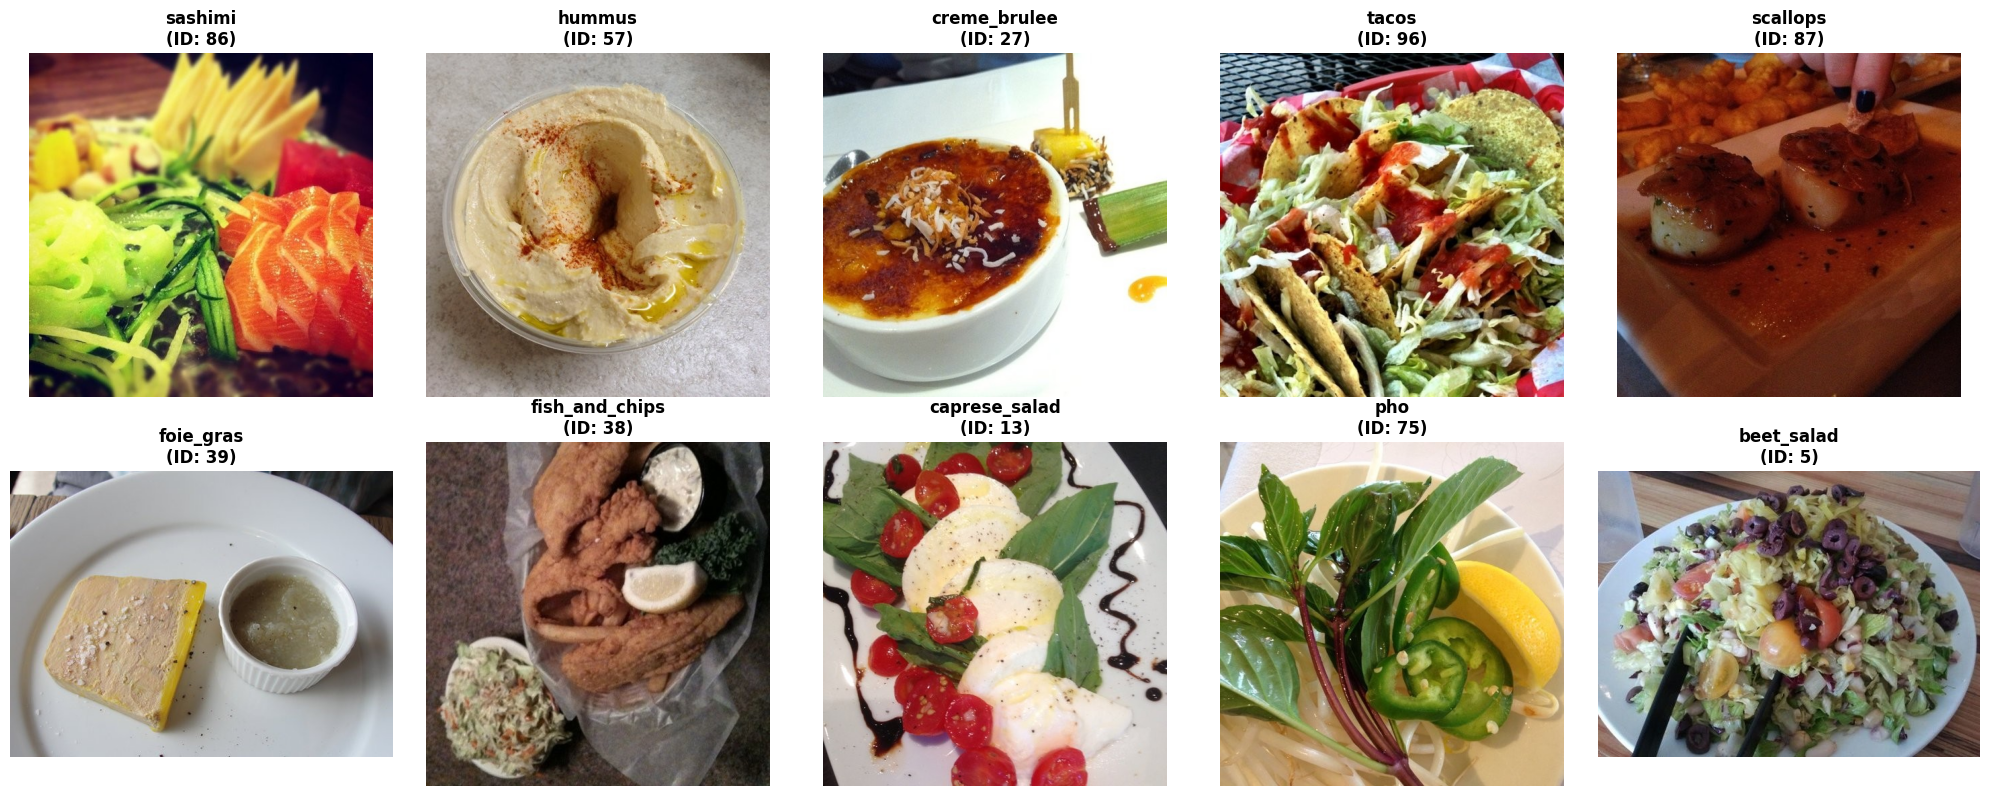


Dataset contains 101 food classes


In [0]:
unique_classes = train_data['label'].unique()
random_classes = random.sample(list(unique_classes), min(10, len(unique_classes)))

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(random_classes):
    class_samples = train_data[train_data['label'] == class_name]
    sample = class_samples.sample(1).iloc[0]
    img = Image.open(io.BytesIO(sample['image_bytes'])).convert('RGB')
    axes[idx].imshow(img)
    axes[idx].set_title(f"{sample['label']}\n(ID: {sample['label_id']})", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nDataset contains {len(unique_classes)} food classes")

## Validate Data Integrity

- Proactive validation catches corrupted images before training, preventing cryptic failures hours later
- This step is optional for trusted data sources but recommended for production ML pipelines
- For very large datasets, push validation upstream to the ETL stage for better scalability

In [0]:
def validate_data(data, name):
    corrupted_indices = []
    for idx in range(len(data)):
        try:
            img_bytes = data.iloc[idx]['image_bytes']
            if img_bytes is None or len(img_bytes) == 0:
                corrupted_indices.append(idx)
                continue
            Image.open(io.BytesIO(img_bytes)).convert('RGB')
        except:
            corrupted_indices.append(idx)
    
    if corrupted_indices:
        print(f"Removing {len(corrupted_indices)} corrupted {name} samples")
        data = data.drop(data.index[corrupted_indices]).reset_index(drop=True)
    return data

train_data = validate_data(train_data, "training")
val_data = validate_data(val_data, "validation")

print(f"Clean data - Train: {len(train_data)} | Val: {len(val_data)}")

Clean data - Train: 15150 | Val: 5050


## Create PyTorch Dataset

- Custom `Dataset` class enables lazy loading - images loaded on-demand during training, not all at once
- `AutoImageProcessor` handles model-specific preprocessing (Vision Transformer expects 224x224 normalized images)
- `.squeeze()` removes batch dimension since Hugging Face Trainer expects individual tensors per sample

In [0]:
class Food101Dataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row['image_bytes'])).convert('RGB')
        encoding = self.processor(image, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(row['label_id'], dtype=torch.long)
        return encoding

processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
train_dataset = Food101Dataset(train_data, processor)
val_dataset = Food101Dataset(val_data, processor)

print(f"Datasets created: {len(train_dataset)} train, {len(val_dataset)} val")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Datasets created: 15150 train, 5050 val


## Initialize Model and Training Configuration

- Transfer learning: load pre-trained Vision Transformer weights, then fine-tune on Food101
- `ignore_mismatched_sizes=True` replaces the classifier head while keeping feature extraction layers
- Gradient accumulation simulates larger batch sizes (4×8=32 effective) without GPU memory overflow
- Mixed precision (FP16) typically provides 2-3x speedup on GPU with negligible accuracy impact

In [0]:
output_dir = "/tmp/food101_cv_training"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="/tmp/logs",
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
    fp16=torch.cuda.is_available(),
    warmup_steps=100,
)

print(f"Device: {device} | Effective batch size: {BATCH_SIZE * 4} | FP16: {torch.cuda.is_available()}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda | Effective batch size: 32 | FP16: True


## Define Metrics

- Weighted F1 score handles class imbalance better than raw accuracy
- Metrics computed on validation set at the end of each epoch to track generalization
- For datasets with many visually similar classes, consider adding top-5 accuracy as well

In [0]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

## Train Model with MLflow Tracking

- MLflow automatically logs hyperparameters, training curves, and model artifacts for reproducibility
- Saving to `/tmp` first avoids DBFS write latency during training (faster I/O)
- The `run` object reference is needed for model registration - keep it in scope
- Learn more: [MLflow Model Training](https://docs.databricks.com/aws/en/mlflow/)

In [0]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

with mlflow.start_run(run_name="food101_cv_training") as run:
    mlflow.log_param("model_checkpoint", MODEL_CHECKPOINT)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("num_epochs", NUM_EPOCHS)
    mlflow.log_param("train_samples", len(train_dataset))
    mlflow.log_param("val_samples", len(val_dataset))
    
    train_result = trainer.train()
    eval_result = trainer.evaluate()
    
    final_model_path = "/tmp/food101_final_model"
    trainer.save_model(final_model_path)
    processor.save_pretrained(final_model_path)
    
    mlflow.log_metrics({
        "train_loss": train_result.training_loss,
        "val_accuracy": eval_result["eval_accuracy"],
        "val_f1": eval_result["eval_f1"],
        "val_loss": eval_result["eval_loss"]
    })
    
    print(f"Training Complete - Loss: {train_result.training_loss:.4f} | Accuracy: {eval_result['eval_accuracy']:.4f} | F1: {eval_result['eval_f1']:.4f}")

Training Complete - Loss: 0.7500 | Accuracy: 0.8410 | F1: 0.8420
🏃 View run food101_cv_training at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/3825708664079979/runs/9c713ae190c74b968cedfae7c836e791
🧪 View experiment at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/3825708664079979


## Register Model to Unity Catalog

- Unity Catalog provides enterprise governance: role-based access control, lineage tracking, and audit logs
- Automatic versioning: each registration creates a new version, enabling A/B testing and rollbacks
- `input_example` enables automatic signature inference and validates model inputs/outputs
- Learn more: [Unity Catalog ML](https://docs.databricks.com/aws/en/machine-learning/manage-model-lifecycle/index.html)

In [0]:
final_model_path = "/tmp/food101_final_model"
trained_model = AutoModelForImageClassification.from_pretrained(final_model_path)
trained_processor = AutoImageProcessor.from_pretrained(final_model_path)

sample_input = trained_processor(
    Image.open(io.BytesIO(train_data.iloc[0]['image_bytes'])).convert('RGB'),
    return_tensors="pt"
)
sample_input_df = pd.DataFrame({
    "pixel_values": [sample_input['pixel_values'].numpy().tolist()]
})

with mlflow.start_run(run_id=run.info.run_id):
    model_info = mlflow.transformers.log_model(
        transformers_model={
            "model": trained_model,
            "image_processor": trained_processor
        },
        artifact_path="model",
        task="image-classification",
        registered_model_name=f"{CATALOG}.{SCHEMA}.{MODEL_NAME}",
        input_example=sample_input_df.iloc[:1]
    )
    
    print(f"Model registered: {CATALOG}.{SCHEMA}.{MODEL_NAME}")
    print(f"Model URI: {model_info.model_uri}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
2025/11/10 23:08:35 WARNING mlflow.transformers: The model card could not be retrieved from the hub due to Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/tmp/food101_final_model'. Use `repo_type` argument if needed.
2025/11/10 23:08:35 WARNING mlflow.transformers: Unable to find license information for this model. Please verify permissible usage for the model you are storing prior to use.
2025/11/10 23:08:35 INFO mlflow.transformers.signature: Running model prediction to infer the model output signature with a timeout of 180 seconds. You can specify a different timeout by setting the environment variable MLFLOW_INPUT_EXAMPLE_INFERENCE_TIMEOUT.
2025/11/10 23:08:35 WARNING mlflow.transformers.signature: Attempted to generate a signature for the saved pipeline but encountered an error. Fall back to the default signature for 

cannot access local variable 'model' where it is not associated with a value
cannot access local variable 'model' where it is not associated with a value


2025/11/10 23:08:56 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel_values"
    ],
    "data": [
      [
        [
          [
            [
              [
                -0.7098039388656616,
                -0.7098039388656616,
                -0.7098039388656616,
                -0.6941176652908325,
                -0.6941176652908325,
                -0.6941176652908325,
                -0.6941176652908325,
                -0.6941176652908325,
                -0.6941176652908325,
                -0.686274528503418,
                -0.6784313917160034,
                -0.6784313917160034,
                -0.686274528503418,
                -0.6705882549285889,
                -0.6627451181411743,
                -0.6549019813537598,
                -0.6549019813537598,
                -0.6470588445663452,
                -0.6549019813537598,
                -0.6627451181411743,
                -0.647058844

Uploading artifacts:   0%|          | 0/14 [00:00<?, ?it/s]

Registered model 'jdub_demo_aws.food101.food101_cv_classifier' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/14 [00:00<?, ?it/s]

Created version '3' of model 'jdub_demo_aws.food101.food101_cv_classifier'.


Model registered: jdub_demo_aws.food101.food101_cv_classifier
Model URI: runs:/9c713ae190c74b968cedfae7c836e791/model
🏃 View run food101_cv_training at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/3825708664079979/runs/9c713ae190c74b968cedfae7c836e791
🧪 View experiment at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/3825708664079979


## Test Inference

- The `@champion` alias points to your production model version (managed via Unity Catalog UI or API)
- Loading from Unity Catalog ensures you test the exact registered artifact, not local files
- Test both prediction correctness and latency before deploying to serving endpoints
- Consider testing edge cases: blurry images, unusual camera angles, or visually ambiguous foods

Loading model: models:/jdub_demo_aws.food101.food101_cv_classifier@champion


2025/11/10 23:09:07 INFO mlflow.transformers: 'models:/jdub_demo_aws.food101.food101_cv_classifier@champion' resolved as 's3://databricks-e2demofieldengwest/b169b504-4c54-49f2-bc3a-adf4b128f36d/models/06e2b6ca-10a0-4705-a0c5-c0c663a981bc/versions/2cdf8b1a-9575-4358-b36b-4141ec1aa30e'


2025/11/10 23:09:08 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


cannot access local variable 'model' where it is not associated with a value
cannot access local variable 'model' where it is not associated with a value
Model loaded successfully


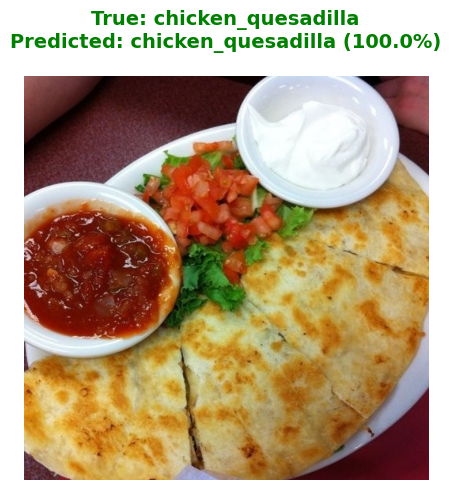


INFERENCE TEST
Model: models:/jdub_demo_aws.food101.food101_cv_classifier@champion
True Label: chicken_quesadilla (ID: 19)
Predicted: chicken_quesadilla (Confidence: 100.0%)
Status: ✓ CORRECT

Top 5 Predictions:
  → 1. chicken_quesadilla             100.0%
    2. breakfast_burrito              92.5%
    3. huevos_rancheros               86.1%
    4. tacos                          85.6%
    5. nachos                         84.7%


In [0]:
model_full_name = f"{CATALOG}.{SCHEMA}.{MODEL_NAME}"
model_uri = f"models:/{model_full_name}@champion"
print(f"Loading model: {model_uri}")

loaded_model = mlflow.transformers.load_model(model_uri)
print(f"Model loaded successfully")

food_classes_df = spark.table(FULL_TABLE_NAME).select("label_id", "label").distinct().orderBy("label_id")
label_id_to_name = {row['label_id']: row['label'] for row in food_classes_df.collect()}

df_test = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(100)
test_data = df_test.select("image_bytes", "label_id", "label").toPandas()

test_idx = 3
test_image = Image.open(io.BytesIO(test_data.iloc[test_idx]['image_bytes'])).convert('RGB')
true_label = test_data.iloc[test_idx]['label']
true_label_id = test_data.iloc[test_idx]['label_id']

result = loaded_model(test_image, top_k=5)

def map_label(pred):
    label = pred['label']
    if label.startswith('LABEL_'):
        label_id = int(label.split('_')[1])
        return label_id_to_name.get(label_id, label)
    return label

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_image)
ax.axis('off')

pred_label = map_label(result[0])
is_correct = pred_label == true_label
color = 'green' if is_correct else 'red'

ax.set_title(f"True: {true_label}\nPredicted: {pred_label} ({result[0]['score']:.1%})",
             fontsize=14, fontweight='bold', color=color, pad=20)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"INFERENCE TEST")
print(f"{'='*60}")
print(f"Model: {model_uri}")
print(f"True Label: {true_label} (ID: {true_label_id})")
print(f"Predicted: {pred_label} (Confidence: {result[0]['score']:.1%})")
print(f"Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
print(f"\nTop 5 Predictions:")
for i, pred in enumerate(result[:5], 1):
    food_name = map_label(pred)
    marker = "→" if food_name == true_label else " "
    print(f"  {marker} {i}. {food_name:<30} {pred['score']:.1%}")
print(f"{'='*60}")

In [0]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Model: Vision Transformer fine-tuned on Food101")
print(f"Registry: {CATALOG}.{SCHEMA}.{MODEL_NAME}")
print(f"Model URI: models:/{CATALOG}.{SCHEMA}.{MODEL_NAME}@champion")
print(f"\nNext Steps:")
print(f"  → Use this model in 02-Conformal-Wrapper.ipynb for conformal prediction")
print("="*60)

TRAINING SUMMARY
Model: Vision Transformer fine-tuned on Food101
Registry: jdub_demo_aws.food101.food101_cv_classifier
Model URI: models:/jdub_demo_aws.food101.food101_cv_classifier@champion

Next Steps:
  → Use this model in 02-Conformal-Wrapper.ipynb for conformal prediction
